In [1]:
# LINKS:
# talk: https://docs.google.com/presentation/d/1p-snwasqNV4V6_h8FRd277g4_uG35U9rRVEOQ2C9D9c/edit?usp=sharing
# psana1 documentation: https://confluence.slac.stanford.edu/display/PSDM/psana+python+Setup
# slurm batch system documentation: https://confluence.slac.stanford.edu/display/PCDS/Submitting+SLURM+Batch+Jobs
# ami2 documentation: https://confluence.slac.stanford.edu/display/LCLSIIData/ami
# jupyterhub access: https://pswww.slac.stanford.edu/jupyterhub/hub/home

In [2]:
# defining experiment and run to analyze
# need to be on a "psana" node to see data! 
from psana import *
ds = MPIDataSource('exp=xpptut15:run=59:smd')

In [3]:
# learning which detectors are in this experiment/run
detNames = DetNames()
print('*** Detector Names (Full-Name, DAQ-Alias, User-Alias) ***')
for detname in DetNames(): print(detname)
 
epicsNames = DetNames('epics')
print('*** Some Epics Names (Full-Name, DAQ-Alias, User-Alias) ***')
for ename in epicsNames[:4]: print(ename) # only print a few

*** Detector Names (Full-Name, DAQ-Alias, User-Alias) ***
('XppSb3Pim.1:Tm6740.1', 'yag2', '')
('NoDetector.0:Evr.1', 'evr1', '')
('XppEndstation.0:Gsc16ai.0', 'adc', '')
('XppMonPim.1:Tm6740.1', 'yag_lom', '')
('XppEndstation.0:USDUSB.0', 'usbencoderLOM', '')
('NoDetector.0:Evr.0', 'evr0', '')
('XppGon.0:Cspad.0', 'cspad', '')
('XppLas.0:OceanOptics.1', 'oospec_HR', '')
('XppLas.0:OceanOptics.0', 'oospec_USB', '')
('EBeam', '', '')
('PhaseCavity', '', '')
('FEEGasDetEnergy', '', '')
('XppSb2_Ipm', '', '')
('XppSb3_Ipm', '', '')
('XppEnds_Ipm0', '', '')
('XppEndstation.0:Opal1000.1', 'opal_1', '')
('ControlData', '', '')
*** Some Epics Names (Full-Name, DAQ-Alias, User-Alias) ***
('HX2:DVD:GCC:01:PMON', '', '')
('HX2:DVD:GPI:01:PMON', '', '')
('HX2:DVD:PIP:01:VMON', '', '')
('HX2:SB1:IPM:01:ChargeAmpRangeCH0', 'ipm1_gain', '')


In [4]:
# creating a detector object
det = Detector('cspad')

In [5]:
# iterating over events
ds.break_after(5) # standard python break statements can hang parallel psana jobs
for evt in ds.events():
    print('Processing event!')

Processing event!
Processing event!
Processing event!
Processing event!
Processing event!


In [6]:
# explore the Detector objects to avoid searching for and reading documentation:
#   position cursor after "det." below and hit TAB to explore the capabilities of an object
#   position cursor after "det.calib" below and hit shift-TAB to see python "docstring" documentation
det.calib(evt).shape # det.calib(evt) returns an UNASSEMBLED calibrated 3D array with 32 panels

(32, 185, 388)

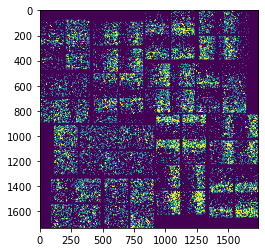

In [7]:
# det.image(evt) returns a 2D ASSEMBLED calibrated array with the 32 panels layed out on an "approximate" uniform 2D grid
img = det.image(evt)
import matplotlib.pyplot as plt
plt.imshow(img,vmin=0,vmax=1)
plt.show()

In [8]:
# a few other detectors, unfortunately with slightly different interfaces (fixed for psana2/LCLS2)
ebeamDet = Detector('EBeam') # BeamLineData ("BLD") from the accelerator
epicsVar = Detector('HX2:DVD:GCC:01:PMON') # slow "EPICS" data, like temperatures
evr = Detector('evr0') # timing system information, e.g. was there xray beam in this event? did a laser fire?
for evt in ds.events():
    ebeam = ebeamDet.get(evt)
    value = epicsVar()
    codes = evr.eventCodes(evt)
    if ebeam is None or value is None or codes is None: # important to check for missing data on every event!
        print('Missing data!',ebeam,value,codes)
    else:
        print('Found photon energy:',ebeam.ebeamPhotonEnergy(),'epics value:',value,'event codes:',codes)
        break

Found photon energy: 0.0 epics value: 4.5e-09 event codes: [140, 141, 142, 143, 144, 41, 42, 43, 44, 40]


In [9]:
# we will now run an example in the terminal using the slurm batch system to produce a small hdf5 file: run54.h5

In [13]:
# read in the small hdf5 file produced above.  Make sure to not use up too much memory!
import h5py
f = h5py.File('run54.h5')
#cspad_roi = f['cspad_roi'][:] # this sort of line that can use up too much memory
print(f['cspad_roi'][:5])

[[ 1.8709639 -2.1760333]
 [-1.5286504  1.4243525]
 [-3.666312   3.286691 ]
 [ 3.0526133 -3.9943838]
 [ 1.237622  -4.8093753]]


In [11]:
# analyzing a "step scan"
from psana import *
ds = MPIDataSource('exp=xpptut15:run=200:smd')
cd = Detector('ControlData')
for nstep,step in enumerate(ds.steps()):
    pvList = cd().pvControls()
    for pv in pvList:
        print('Step',nstep,'name/value:',pv.name(),pv.value())
    for evt in step.events():
        pass
    if nstep>1: break

Step 0 name/value: lxt_vitara_ttc -1.0000000010863949e-12
Step 1 name/value: lxt_vitara_ttc -7.500000003912797e-13
Step 2 name/value: lxt_vitara_ttc -4.999999996961645e-13


In [12]:
# jumping quickly to events
ds = MPIDataSource('exp=xpptut15:run=54:smd')
 
# LCLS uses 3 numbers to define an event.  In LCLS2 this is one number.
seconds     = []
nanoseconds = []
fiducials   = []
 
# get some times of events (these could come from a saved "small data" file, for example)
for nevent,evt in enumerate(ds.events()):
    evtId = evt.get(EventId)
    seconds.append(evtId.time()[0])
    nanoseconds.append(evtId.time()[1])
    fiducials.append(evtId.fiducials())
    if nevent==2: break
 
# now that we have the times, use them to jump to the events in reverse order
ds = DataSource('exp=xpptut15:run=54:idx') # not an MPIDataSource! (more elegant in psana2/LCLS2)
run = next(ds.runs())
for sec,nsec,fid in zip(reversed(seconds),reversed(nanoseconds),reversed(fiducials)):
    et = EventTime(int((sec<<32)|nsec),fid)
    evt = run.event(et)
    print(evt.get(EventId).fiducials())

59544
59541
59538


In [ ]:
# we will now see an AMI2 demo (real-time graphical analysis with <1s latency) built on top of psana